# Population structure

The exercises in this notebook were adopted from: 
https://github.com/joellembatchou/SISG2022_Association_Mapping/blob/master/code/Session02_exercises.R

# Set up

## Paths

In [8]:
DIR_MAIN = '..'

In [9]:
%%bash -s "$DIR_MAIN"
DIR_MAIN=$1

ls $DIR_MAIN

Workshop_regeneron_UNAM_AZ.docx
code
data
material
notes
slides
tools


## Tools

A list of tools: PLINK2.

In [10]:
PLINK = f'{DIR_MAIN}/tools/plink2'

In [11]:
%%bash -s "$PLINK"
PLINK=$1

$PLINK --version

PLINK v2.00a3.7 64-bit (24 Oct 2022)


## Datasets

In [12]:
DIR_DATA = f'{DIR_MAIN}/data/'
D1_BFILE = f'{DIR_DATA}/YRI_CEU_ASW_MEX_NAM'
D1_LABS = f'{DIR_DATA}/Population_Sample_Info.txt'

## R enviroment

In [2]:
%%bash
R --version

R version 4.4.0 (2024-04-24) -- "Puppy Cup"
Copyright (C) 2024 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin22.6.0

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [3]:
 import rpy2.ipython

In [4]:
%%capture
%load_ext rpy2.ipython

In [5]:
%%R
 print('Hello World from R!')

[1] "Hello World from R!"


In [13]:
%%R
library(tidyverse)
library(data.table)

In [14]:
%%R
library(BEDMatrix)

# Explore the dataset

In [15]:
%%R -i D1_BFILE
bmat = BEDMatrix(D1_BFILE, simple_names = TRUE)

R[write to console]: Extracting number of samples and rownames from YRI_CEU_ASW_MEX_NAM.fam...

R[write to console]: Extracting number of variants and colnames from YRI_CEU_ASW_MEX_NAM.bim...



In [16]:
%%R
dim(bmat)

[1]    604 150872


In [17]:
%%R
rownames(bmat) %>% head

[1] "HGDP00702" "HGDP00703" "HGDP00704" "HGDP00706" "HGDP00708" "HGDP00710"


In [18]:
%%R -i D1_LABS
labs = fread(D1_LABS) %>% as_tibble

In [19]:
%%R
str(labs)

tibble [604 × 3] (S3: tbl_df/tbl/data.frame)
 $ FID       : chr [1:604] "1432" "1433" "1434" "1436" ...
 $ IID       : chr [1:604] "HGDP00702" "HGDP00703" "HGDP00704" "HGDP00706" ...
 $ Population: chr [1:604] "NAM" "NAM" "NAM" "NAM" ...
 - attr(*, ".internal.selfref")=<externalptr> 


# PCA by Plink

PCA analysis by Plink with some caveats:

- SNPs are not pruned / passed QC filters
- All SNPs are used 
- All samples are used regardless of the relatedness

In [20]:
%%bash -s "$PLINK" "$D1_BFILE"
PLINK=$1
D1_BFILE=$2

cmd="$PLINK --bfile $D1_BFILE
    --pca 10 --out pca_plink"
eval $cmd

PLINK v2.00a3.7 64-bit (24 Oct 2022)           www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pca_plink.log.
Options in effect:
  --bfile ../data//YRI_CEU_ASW_MEX_NAM
  --out pca_plink
  --pca 10

Start time: Wed Sep  4 22:05:33 2024
16384 MiB RAM detected; reserving 8192 MiB for main workspace.
Using up to 12 threads (change this with --threads).
604 samples (316 females, 288 males; 433 founders) loaded from
../data//YRI_CEU_ASW_MEX_NAM.fam.
150872 variants loaded from ../data//YRI_CEU_ASW_MEX_NAM.bim.
Note: No phenotype data present.
Calculating allele frequencies... 0%43%86%done.
Constructing GRM: 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%

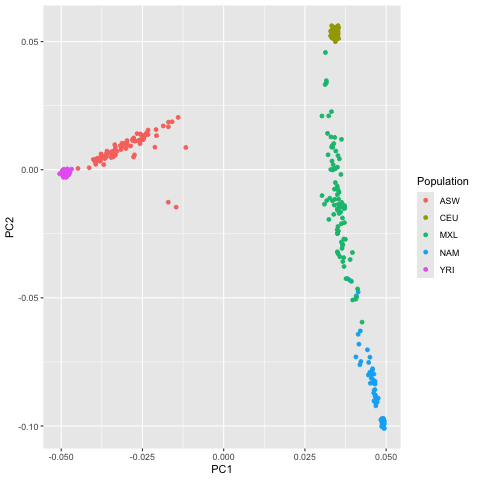

In [23]:
%%R
# load PC scores from PLINK output file
pcs = fread('pca_plink.eigenvec') 
pcs = full_join(pcs, labs, by = 'IID')

# scatterplot of PC1 vs PC2
ggplot(pcs, aes(PC1, PC2)) + geom_point(aes(color = Population))

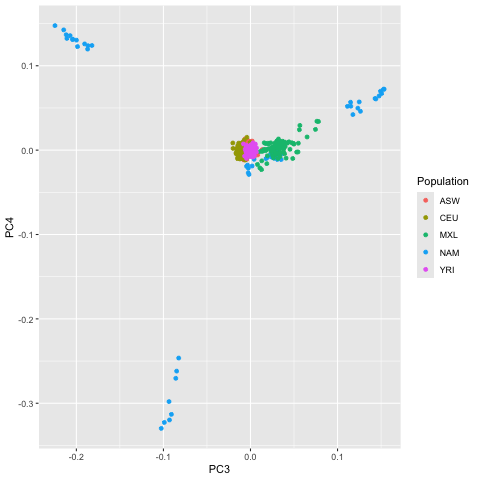

In [25]:
%%R
# scatterplot of PC3 vs PC4
ggplot(pcs, aes(PC3, PC4)) + geom_point(aes(color = Population))

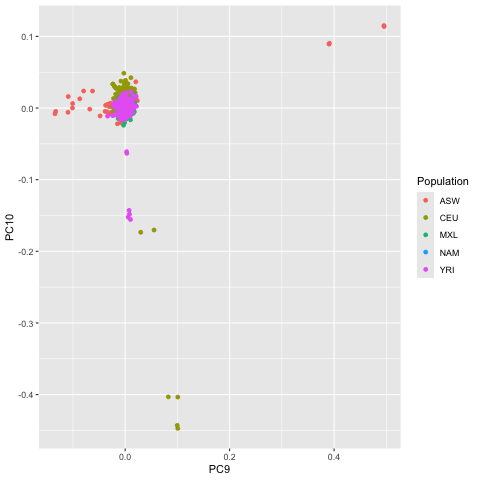

In [27]:
%%R 
# scatterplot of PC9 vs PC10
ggplot(pcs, aes(PC9, PC10)) + geom_point(aes(color = Population))

In [31]:
%%R 
# variance captured by PCs
evals = read_lines('pca_plink.eigenval') %>% as.numeric
prop = evals / sum(evals)

data.frame(PC = 1:10, VarExplained = round(prop, 2))

   PC VarExplained
1   1         0.61
2   2         0.22
3   3         0.03
4   4         0.02
5   5         0.02
6   6         0.02
7   7         0.02
8   8         0.02
9   9         0.02
10 10         0.02


# PCA by bigsnpr

In [33]:
%%R 
library(bigsnpr)

R[write to console]: Loading required package: bigstatsr



In [35]:
%%R 
bedfile = paste0(D1_BFILE, '.bed')
bed = bed(bedfile)
pca = bed_autoSVD(bed, thr.r2 = 0.2, min.mac = 20, k = 10)


Phase of clumping (on MAC) at r^2 > 0.2.. keep 87127 variants.
Discarding 48 variants with MAC < 20.

Iteration 1:
Computing SVD..


R[write to console]: The default of 'doScale' is FALSE now for stability;
  set options(mc_doScale_quiet=TRUE) to suppress this (once per session) message



0 outlier variant detected..

Converged!


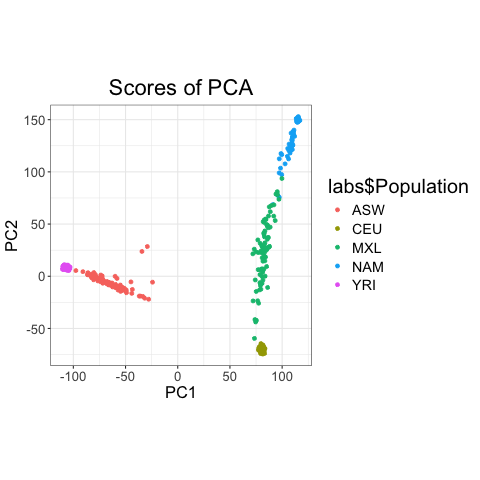

In [36]:
%%R 
# plot PC1 vs PC2
plot(pca, type = "scores", scores = 1:2) + aes(color = labs$Population)

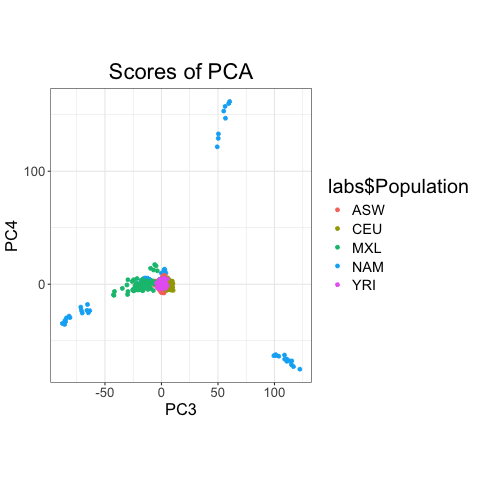

In [37]:
%%R 
# plot PC3 vs PC4
plot(pca, type = "scores", scores = 3:4) + aes(color = labs$Population)

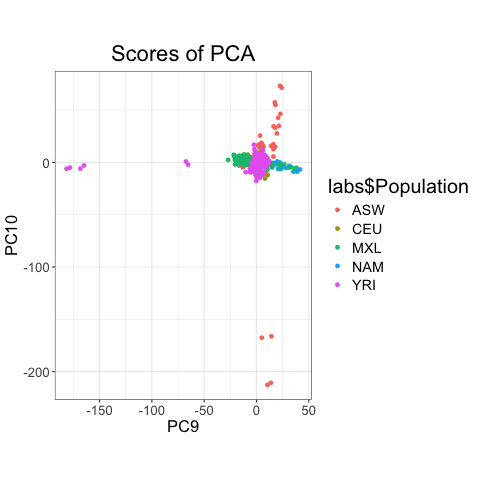

In [38]:
%%R 
# plot PC9 vs PC10
plot(pca, type = "scores", scores = 9:10) + aes(color = labs$Population)

In [ ]:
%%R 
# check SNP loadgings
plot(pca, type = "loadings", loadings = 1:10, coeff = 0.4)